In [1]:
from models import MeshModel, IcosphereModel
import jax.numpy as jnp
from models.mesh_transform import add_rotation, evaluate_rotation
from plots import plot_3D

In [2]:
m = IcosphereModel.construct(1000, 1., 1., 1., jnp.ones(20))

In [3]:
mt = add_rotation(m, 1000.)

In [4]:
mt1 = evaluate_rotation(mt, 0)

In [5]:
jnp.max(mt1.los_velocities)

Array(988.1614, dtype=float32)

In [6]:
jnp.max(mt1.velocities)

Array(992.7091, dtype=float32)

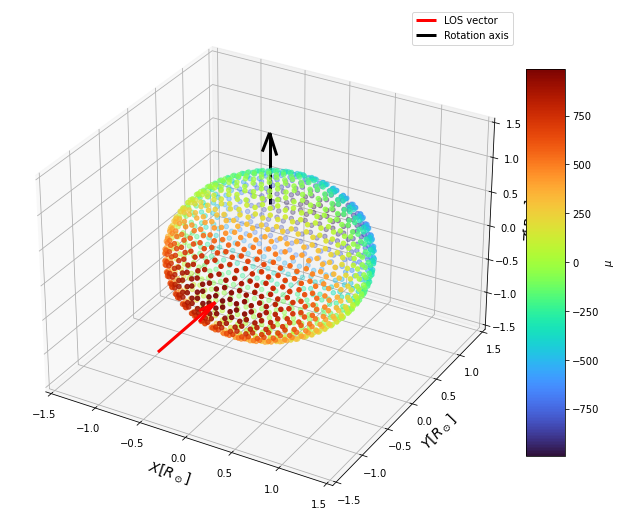

In [7]:
plot_3D(mt1, 'los_velocities')